# Forest Fire visualization project

In [256]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.palettes import Category20c
from bokeh.transform import cumsum, linear_cmap
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Grid, LinearInterpolator

from IPython import __version__ as ipython_version
from pandas import __version__ as pandas_version
from bokeh import __version__ as bokeh_version

output_notebook()

Loading BokehJS ...

In [268]:
ff = pd.read_csv('../data/raw/forestfires.csv')
print(ff.shape)
ff.head()

(517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [258]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

In [259]:
ff['month'] = pd.Categorical(ff['month'], categories=months, ordered=True)
ff = ff.reset_index(ff.sort_values(by='month', inplace=True), drop=True)
ff.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,2,4,jan,sat,82.1,3.7,9.3,2.9,5.3,78,3.1,0.0,0.00
1,4,5,jan,sun,18.7,1.1,171.4,0.0,5.2,100,0.9,0.0,0.00
2,3,4,feb,sat,83.9,8.0,30.2,2.6,12.7,48,1.8,0.0,0.00
3,2,2,feb,fri,86.6,13.2,43.0,5.3,12.3,51,0.9,0.0,0.00
4,7,4,feb,sun,83.9,8.7,32.1,2.1,8.8,68,2.2,0.0,13.05


In [260]:
ff.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


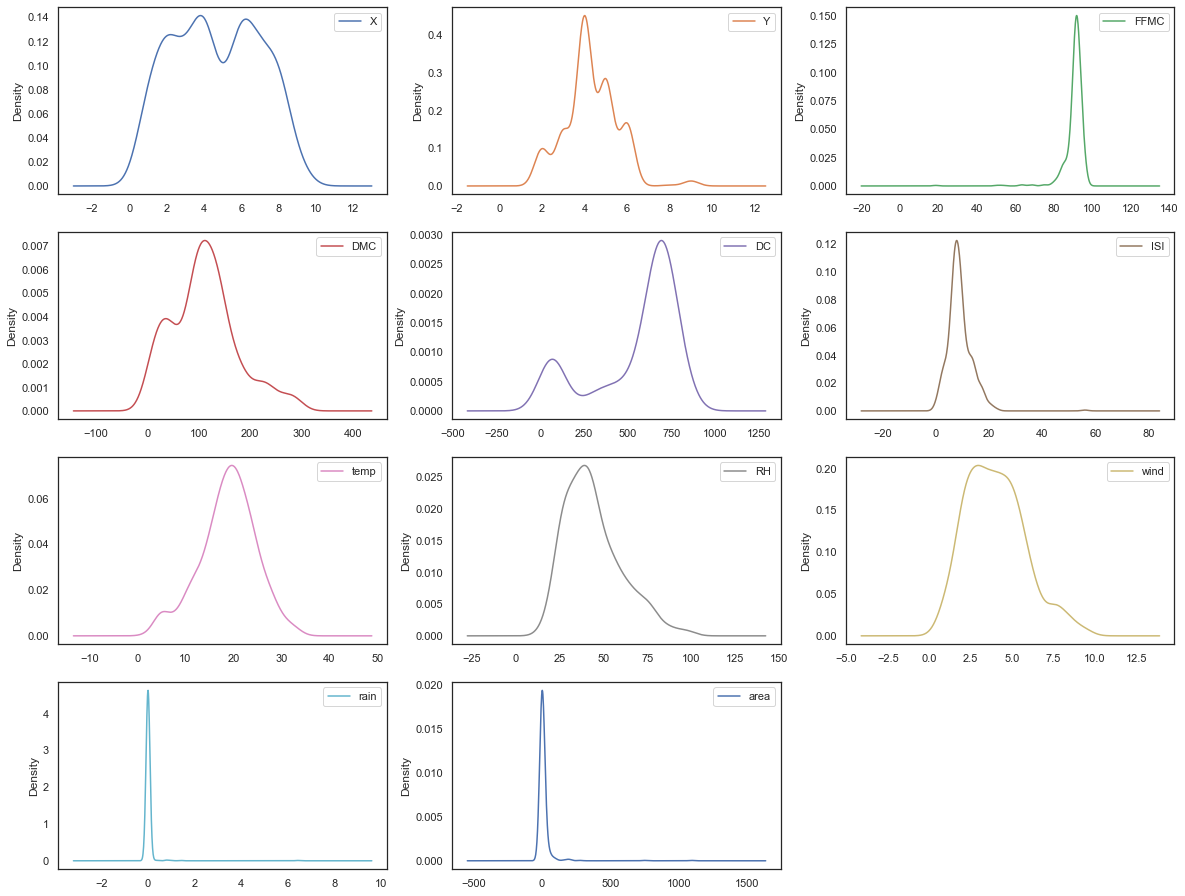

In [261]:
ff.plot(kind='density', subplots=True, layout=(5,3), figsize=(20,20), sharex=False, sharey=False)
plt.show()

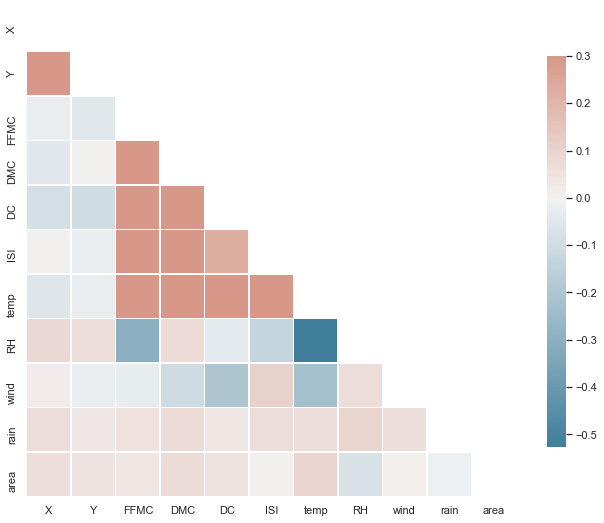

In [262]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = ff.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8})

plt.show()

## What is the distribution of area burnt per month?

In [263]:
source = ColumnDataSource(ff)
areaburnt=ff[ff['area']>0]
areaburnt = dict(zip(areaburnt.month, areaburnt.area))
areaburnt
data = pd.Series(areaburnt).reset_index(name='area').rename(columns={'index':'month'})

data['color'] = Category20c[len(areaburnt)]

# represent each value as an angle = value / total * 2pi
data['angle'] = data['area']/data['area'].sum() * 2*pi

p = figure(plot_height=350, title='Area of fire', toolbar_location=None,
           tools="hover", tooltips="@month: @area", plot_width=800)

p.wedge(x=0, y=1, radius=0.4, 
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='month', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

print(data)

  month   area    color     angle
0   feb   5.39  #3182bd  0.129726
1   mar  27.35  #6baed6  0.658259
2   apr  10.93  #9ecae1  0.263063
3   may  38.48  #c6dbef  0.926136
4   jun   3.19  #e6550d  0.076777
5   jul  86.45  #fd8d3c  2.080676
6   aug   5.23  #fdae6b  0.125876
7   sep  12.64  #fdd0a2  0.304219
8   oct  49.37  #31a354  1.188236
9   dec  22.03  #74c476  0.530217


## Q. How can we visualize the forest fire impact on the map by the area?

In [264]:
url = '/notebooks/images/map.png'

mapper = linear_cmap(field_name='area', 
                     palette=Spectral6, 
                     low=min(ff['area']),
                     high=max(ff['area'])
                    )

size_mapper=LinearInterpolator(
    x=[ff.area.min(),ff.area.max()],
    y=[5,50]
)

p = figure(title='Area of fire',
           x_range=(0,10), 
           y_range=(0,10),
           plot_width=600,
           plot_height=400
          )

p.image_url(url=[url], x=0, y=0, h=10, w=10, anchor="bottom_left")

p.xaxis.axis_label = 'X'
p.yaxis.axis_label = 'Y'

p.scatter('X', 'Y', source=ff, fill_alpha=0.3, size={'field':'area','transform': size_mapper}, color='red')

plot.x_range.flipped = True

show(p)


In [8]:
filtered_ff = ff.select_dtypes(exclude=['object', 'category'])
filtered_ff.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   FFMC    517 non-null    float64
 3   DMC     517 non-null    float64
 4   DC      517 non-null    float64
 5   ISI     517 non-null    float64
 6   temp    517 non-null    float64
 7   RH      517 non-null    int64  
 8   wind    517 non-null    float64
 9   rain    517 non-null    float64
 10  area    517 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 44.6 KB


Text(0.5, 1.0, 'Temperature per month')

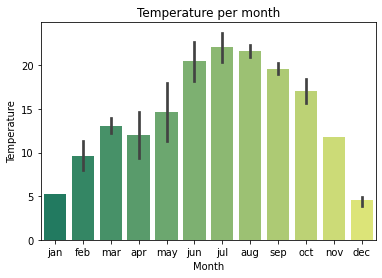

In [9]:
ax = sns.barplot(x='month', y='temp', data=ff, palette='summer')
ax.set_xlabel('Month')
ax.set_ylabel('Temperature')
ax.set_title('Temperature per month')

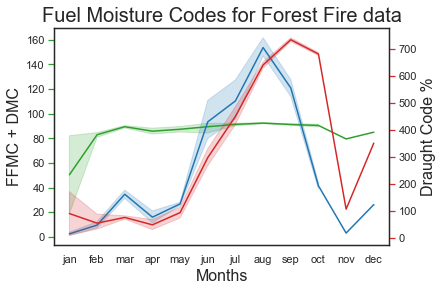

In [266]:
fig, ax1 = plt.subplots()

# FFMC + DMC
ax1_color = 'tab:green'
ax1.set_title('Fuel Moisture Codes for Forest Fire data', fontsize = 20)
ax1.set_xlabel('Months', fontsize = 16)
ax1.set_ylabel('FFMC + DMC', fontsize = 16) 
ax1 = sns.lineplot(data=ff, x='month', y='FFMC', color=ax1_color)
ax1.tick_params(axis='y', color=ax1_color)

ax2_color = 'tab:blue'
ax2 = sns.lineplot(data=ff, x='month', y='DMC', color=ax2_color)

# DC
ax3_color = 'tab:red'
ax3 = ax1.twinx()
ax3.set_ylabel('Draught Code %', fontsize=16)
ax3 = sns.lineplot(x='month', y='DC', data = ff, sort=False, color=ax3_color)
ax3.tick_params(axis='y', color=ax3_color)

#show plot
plt.show()



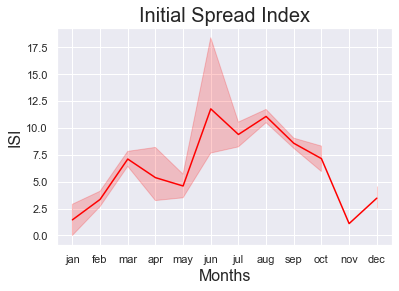

In [267]:
sns.set(style='darkgrid')

sns.lineplot(x='month', y='ISI', data = ff, color='red')

plt.title('Initial Spread Index', fontsize = 20)
plt.xlabel('Months', fontsize = 16)
plt.ylabel('ISI', fontsize = 16) 

plt.show()
